# Simulation 2
## FEP-based attractor network storing digits

**NOTE**: the implementation of the network is in `simulation/network.py`. This is an inefficient implementation, optimized for clarity, instead of speed.

Helper functions are in `simulation/utils.py`.

**This notebook:**
- visualizes the setup:
    - digits dataset
    - network architecture
- performs simultaneous learning and inference: discovers the parameter space focusing on:
    - VFE learning-curves
    - deterministic attractors belonging to each training digit
    - orthogonality of attractors
    - recognition examples and quantification
    - 1-shot generalization examples and quantification


**Details:**
Here, we trained the network on 10 images of handwritten digits (a single example of each of the 10 digits from 0 to 9, 8x8 pixels each, as distributed with scikit-learn, see [](#fig-digits)C, upper row). The remaining 1787 images were unseen in the training phase and only used as a test set, in a one-shot learning fashion. The network was trained with a fixed learning rate of 0.01, through 5000 epochs, each consisting of 10 time steps with the same, randomly selected pattern from the training set of 10 images, while performing simultaneous inference and learning. We evaluated the effect of the inverse temperature parameter $iT$ (i.e. precision) and the strength of evidence during training, i.e. the magnitude of the bias changes $\delta b_i$.
The precision parameter $iT$ was varied with 19 values between 0.01 and 1, and the strength of evidence during training varied by changing the magnitude of the biases from 1 to 20, with increments of 1. The training patterns were first preprocessed by squaring the pixel values (to enhance contrast) and normalizing each image to have zero mean and unit variance. We performed a total of 380 runs, varying these parameters in a grid-search fashion. All cases were evaluated in terms of (i) stochastic (Bayesian) pattern retrieval from noisy variations of the training images; and (ii) one-shot generalization to reconstruct unseen handwritten digit examples. In both types of evaluation, the network was presented a noisy variant of a randomly selected (training or test) image through its biases. The noisy patterns were generated by adding Gaussian noise with a standard deviation of 1 to the pixel values of the training images (see "Examples" in [](#fig-digits)B C and D). The network's response was obtained by averaging 100 time steps of stochastic inference. The performance was quantified as the improvement in the proportion of variance in the original target pattern (without noise) explained by the network's response, compared to that explained by the noisy input pattern (without noise), as compared to the variance explained by the noisy pattern. Both for retrieval and generalization, this approach was repeated 100 times, with a randomly sampled image from the training (10 images) and test set (1787 images), respectively. The median improvement across these 100 repetition was used as the primary performance metric. The retreival and 1-shot generalization performance of models trained with different $iT$ and $\alpha$ parameters is shown on [](#fig-digits)A, top row). We found that, while retrieval of a noisy training pattern was best with precision values between 0.1 and 0.5, generalization to new data peferred lower precision during learning ($iT$<0.1, i.e. more stochatsic dynamics).
Furtermore, in all simulation cases, we seeded the networks with the original test patterns and obtained the corresponding attractor states, by means of deterministic inference. We then computed the pairwise correlation and dot product between the attractor states. The dot product was converted to degrees. Orthogonality was finally quantified by the mean correlation among attractors and and the mean squared deviation from orthogonality (in degrees). The same procedure was also repeated for the original patterns (after preprocessing), which displayed a mean correlation a 29.94 degree mean squared deviation from orthogonality. Attractor orthogonality and the number of attractors for each simulation case is shown on [](#fig-digits)A, bottom row.
We found that depending on the temperature of the network during the learning phase, the network can be in characteristic regimes of high, low and balanced complexity ([](#fig-digits)B). With low temperature (high precision), high model complexity is allowed ("accuracy pumping") and attractors will tend to exactly match the training data [](#fig-digits)C. On the contrary, high temperatures (low precision) result in a single fixed point attractor and reduced recognition performance [](#fig-digits)E. However, such networks will be able to generalize to new data, suggesting the existence of "soft attractors" (e.g. saddle-like structures) that are not local minima on the free energy landscape, yet affect the steady-state posterior distribution in a non-negligible way (especially with longer mixing-times). A balanced regime [](#fig-digits)D can be found with intermediate training precison, where both recognition and generalization performance are high. This is exactly the regime that promotes attractor orthogonalization, crucial for efficient representation and generalization. The complexity restrictions on these models cause them to re-use the same attractors to represent different patterns (see e.g. the single attractor belonging to the digits 5 and 7 in the example on panel D), which eventually leads to less attractors, with each having more explanatory power, and being approximately orthogonal to each other. Panels C-E on [](#fig-digits) provide examples of network behavior on a handwritten digit task across different regimes, including (i) training data (same in all cases); (ii) fixed-point attractors (obtained with deterministic update); (iii) attractor-orthogonality (polar histogram of the pairwise angles beteen attractors); (iv) retrieval and 1-shot generalization performance ($R^2$ between the noisy input pattern and the network output after 100 time steps, for 100 randomly sampled patterns) and (v) illustrative example cases from the recognition and 1-shot generalization tests (noisy input, network output and true pattern).

### Import dependencies

In [18]:
import numpy as np
import pickle
from simulation.utils import fetch_digits_data, preprocess_digits_data, run_network, report_network_evaluation, performance_metrics
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm.notebook import tqdm # For progress bar
import warnings

### Fetch digits data

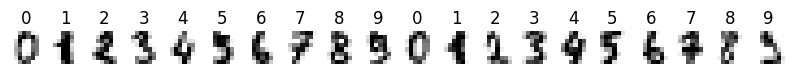

In [14]:
digits = fetch_digits_data()

### Preprocess digits
Intensities will represent evidence. We need to preprocess accordingly.
- square (make evidence higher in pixels of peak intensity)
- normalize (ensure all digits have a comparable overall evidence level)
- visualize

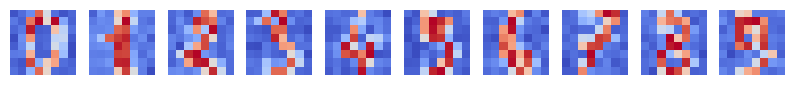

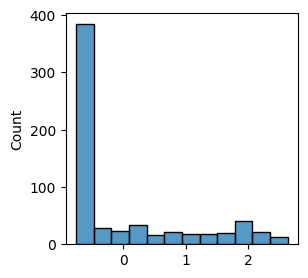

In [15]:
train_data, test_data = preprocess_digits_data(digits)

### Loop over parameters
- evidence_level: 1-20, linear
- inverse_temperature: 0.01 - 10, logarithmic

In [16]:
# Define parameter ranges
n_evidence_levels = 20 # Number of steps for evidence level (adjust as needed)
n_inverse_temperatures = 19 # Number of steps for inverse temperature (adjust as needed)
np.linspace(1, 20, num=n_evidence_levels), np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures), 1/np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
        0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ,
        0.12915497, 0.16681005, 0.21544347, 0.27825594, 0.35938137,
        0.46415888, 0.59948425, 0.77426368, 1.        ]),
 array([100.        ,  77.42636827,  59.94842503,  46.41588834,
         35.93813664,  27.82559402,  21.5443469 ,  16.68100537,
         12.91549665,  10.        ,   7.74263683,   5.9948425 ,
          4.64158883,   3.59381366,   2.7825594 ,   2.15443469,
          1.66810054,   1.29154967,   1.        ]))

## Parameter search

This will take around 30 minutes on 16 cores.

In [5]:
# Define parameter ranges
n_evidence_levels = 20 # Number of steps for evidence level (adjust as needed)
n_inverse_temperatures = 19 # Number of steps for inverse temperature (adjust as needed)
evidence_levels = np.linspace(1, 20, num=n_evidence_levels)
inverse_temperatures = np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures)

# Fixed parameters for the network run during search
search_learning_rate = 0.001
search_num_epochs = 5000
search_num_steps = 10

# Create parameter combinations using itertools.product
param_combinations = [{'evidence_level': ev, 'inverse_temperature': it}
                      for ev, it in itertools.product(evidence_levels, inverse_temperatures)]

print(f"Starting parameter search for {len(param_combinations)} combinations...")
print(f"Evidence levels: {np.round(evidence_levels, 3)}")
print(f"Inverse temperatures: {np.round(inverse_temperatures, 3)}")

# Define the wrapper function to be called by joblib.
# This function takes one parameter combination dict and runs the simulation.

def run_network_wrapper(params):
    """
    Runs the AttractorNetwork simulation for a given set of parameters.
    Assumes 'train_data' and 'run_network' are available in the execution scope.
    """
    # run_network is imported in cell 2
       # train_data is defined in cell 5
    training_output = run_network(
            data=train_data,
            evidence_level=params['evidence_level'],
            inverse_temperature=params['inverse_temperature'],
            learning_rate=search_learning_rate,
            num_epochs=search_num_epochs,
            num_steps=search_num_steps,
            progress_bar=False # Suppress progress bars within parallel runs
    )

    # Return the parameters and the output (network state, attractors, history)
    return {'params': params,
            'nw': training_output[0],
            'training_output': training_output,
            }

print(f"Running {len(param_combinations)} simulations in parallel...")
results = Parallel(n_jobs=-1)(
    delayed(run_network_wrapper)(params) for params in param_combinations
)

print(f"\nParameter search completed. Collected {len(results)} results.")

Starting parameter search for 380 combinations...
Evidence levels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Inverse temperatures: [0.01  0.013 0.017 0.022 0.028 0.036 0.046 0.06  0.077 0.1   0.129 0.167
 0.215 0.278 0.359 0.464 0.599 0.774 1.   ]
Running 380 simulations in parallel...



Parameter search completed. Collected 380 results.


In [6]:
# Save the results to a file
results_filename = 'parameter_search_results.pkl'
try:
    with open(results_filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Results successfully saved to {results_filename}")
except Exception as e:
    print(f"Error saving results: {e}")


Results successfully saved to parameter_search_results.pkl


In [5]:
results_filename = 'parameter_search_results.pkl'
# Optionally, load the results back to verify (or use in a later session)
try:
    with open(results_filename, 'rb') as f:
        results = pickle.load(f)
    print(f"Results successfully loaded from {results_filename}")
    # You can now use loaded_results instead of results if needed
except Exception as e:
    print(f"Error loading results: {e}")

Results successfully loaded from parameter_search_results.pkl


## Estimate performance metrics

In [ ]:

def run_performance_metrics_wrapper(input_dict):
    """
    Runs the AttractorNetwork simulation for a given set of parameters.
    Assumes 'train_data' and 'run_network' are available in the execution scope.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='Mean of empty slice.')
        warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
        warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

        median_delta_r2_retrieval, median_delta_r2_generalization, num_attractors, orthogonality_data, orthogonality_attractors = performance_metrics(
            training_output = input_dict['training_output'],
            train_data = train_data,
            test_data = test_data,
            evidence_level=input_dict['params']['evidence_level'],
            params_retreival={
                                    "num_trials": 100,
                                    "num_steps": 100,
                                    "signal_strength": 0.1,
                                    "SNR": 1,
                                    "inverse_temperature": 1,
                              },
                              params_generalization={
                                    "num_trials": 100,
                                    "num_steps": 100,
                                    "signal_strength": 0.1,
                                    "SNR": 1,
                                    "inverse_temperature": 1,
                              },
            inverse_temperature_deterministic = 1)
        
    return {
        'params': input_dict['params'],
        'nw': input_dict['nw'],
        'median_delta_r2_retrieval': median_delta_r2_retrieval,
        'median_delta_r2_generalization': median_delta_r2_generalization,
        'num_attractors': num_attractors,
        'orthogonality_data': orthogonality_data,
        'orthogonality_attractors': orthogonality_attractors,
    }


print(f"Running {len(results)} performance estimations in parallel...")
performance_results = Parallel(n_jobs=-1)(
    delayed(run_performance_metrics_wrapper)(input_dict) for input_dict in results
)

print(f"\nPerformance metrics estimation completed.")

Running 380 performance estimations in parallel...


In [97]:
import pickle

# Define the filename for saving the results
results_filename = 'performance_results.pkl'

# Save the results list to a file using pickle
try:
    with open(results_filename, 'wb') as f:
        pickle.dump(performance_results, f)
    print(f"Performance results successfully saved to {results_filename}")
except Exception as e:
    print(f"Error saving performance results: {e}")




Performance results successfully saved to performance_results.pkl


In [6]:
results_filename = 'performance_results.pkl'
# Optionally, load the results back to verify (or for later use)
try:
    with open(results_filename, 'rb') as f:
        performance_results = pickle.load(f)
    print(f"Successfully loaded results from {results_filename}")
    # You can add a check here, e.g., comparing len(results) and len(loaded_results)
except Exception as e:
    print(f"Error loading performance results: {e}")

Successfully loaded results from performance_results.pkl


In [9]:
performance_results[0].keys()

dict_keys(['params', 'nw', 'training_output'])

## Visualize performance metrics
### Heatmaps

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data_list = []
for res in performance_results:
    # Check if the result dictionary has the expected keys
    if ('params' in res and
        'median_delta_r2_generalization' in res and
        'median_delta_r2_retrieval' in res and
        'orthogonality_data' in res and
        'orthogonality_attractors' in res and
        'evidence_level' in res['params'] and
        'inverse_temperature' in res['params']):
        data_list.append({
            'evidence_level': res['params']['evidence_level'],
            'inverse_temperature': res['params']['inverse_temperature'],
            'generalization': res['median_delta_r2_generalization'],
            'retrieval': res['median_delta_r2_retrieval'],
            'orthogonality_data': res['orthogonality_data'],
            'orthogonality_attractors': res['orthogonality_attractors'],
            'num_attractors': res['num_attractors']
        })
    else:
        print(f"Skipping result due to missing keys: {res.get('params', 'Params Missing')}")


if not data_list:
    print("No valid results found to plot.")
else:
    df = pd.DataFrame(data_list)
    df['inverse_temperature'] = df['inverse_temperature']

df['T'] = (1/df['inverse_temperature']).round(2)

df.loc[df['num_attractors'] == 1, 'orthogonality_attractors'] = np.nan

import seaborn as sns
pivot_df = df.pivot(index='evidence_level', columns='T', values='retrieval')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='generalization')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='orthogonality_attractors')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm_r', vmin=0, vmax=60, annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='num_attractors')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', vmin=-10, vmax=10, annot=False, fmt='.2f')
plt.show()

Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.01)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.01291549665014884)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.016681005372000592)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.021544346900318832)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.027825594022071243)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.03593813663804628)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0.046415888336127774)}
Skipping result due to missing keys: {'evidence_level': np.float64(1.0), 'inverse_temperature': np.float64(0

NameError: name 'df' is not defined

### Contour plots

In [121]:
np.linspace(-0.33, 0.33, 11)

array([-0.33 , -0.264, -0.198, -0.132, -0.066,  0.   ,  0.066,  0.132,
        0.198,  0.264,  0.33 ])

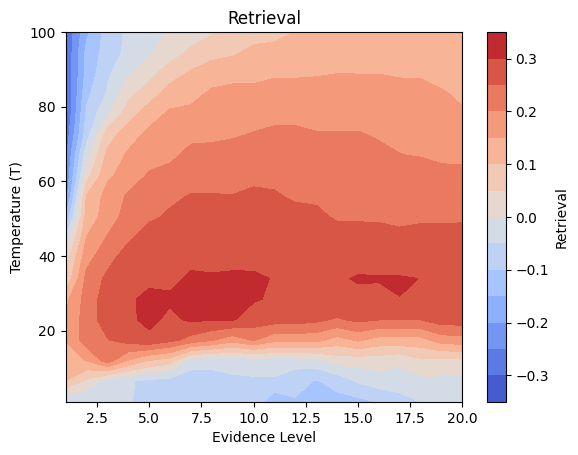

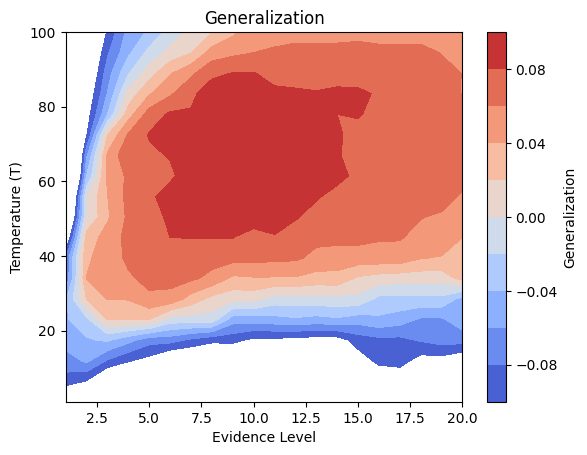

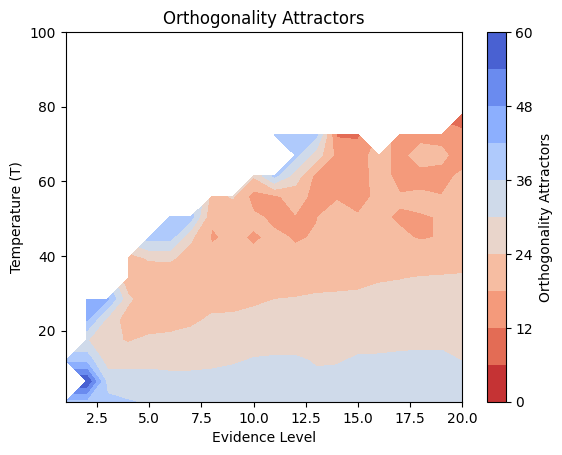

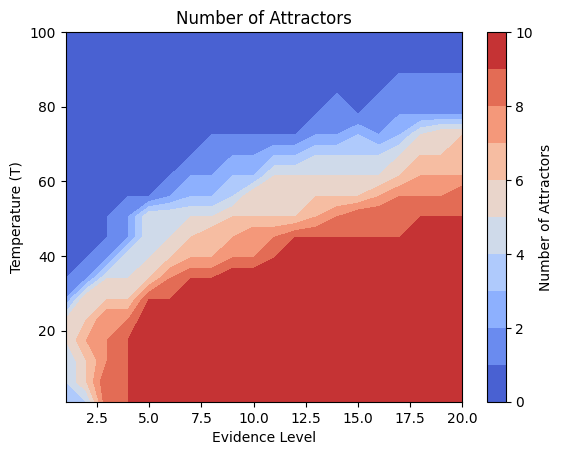

In [131]:
import seaborn as sns
from scipy.ndimage import median_filter # Changed from gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

# Define median filter size
filter_size = 3 # Size 1 means no filtering. Use size > 1 (e.g., 3) for smoothing.

# Retrieval
pivot_df = df.pivot(index='evidence_level', columns='T', values='retrieval')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot = pivot_df.transpose()
x = np.linspace(1, 20, num=n_evidence_levels)#data_to_plot.columns.values # evidence_level
y = np.linspace(100, 1, num=n_inverse_temperatures)#data_to_plot.index.values   # T
z = data_to_plot.values         # retrieval
# Apply median filter
z_filtered = median_filter(z, size=filter_size) # Changed from gaussian_filter
# Create meshgrid for contourf
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, z_filtered, cmap='coolwarm', levels=np.linspace(-0.35, 0.35, 15)) # levels can be adjusted
plt.colorbar(label='Retrieval')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Retrieval') # Removed (Smoothed)
plt.show()

# Generalization
pivot_df_gen = df.pivot(index='evidence_level', columns='T', values='generalization')
pivot_df_gen = pivot_df_gen.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_gen = pivot_df_gen.transpose()
z_gen = data_to_plot_gen.values         # generalization
# Apply median filter
z_gen_filtered = median_filter(z_gen, size=filter_size) # Changed from gaussian_filter
plt.contourf(X, Y, z_gen_filtered, cmap='coolwarm', levels=np.linspace(-0.1, 0.1, 11)) # levels can be adjusted
plt.colorbar(label='Generalization')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Generalization') # Removed (Smoothed)
plt.show()

# Orthogonality Attractors
pivot_df_ortho = df.pivot(index='evidence_level', columns='T', values='orthogonality_attractors')
pivot_df_ortho = pivot_df_ortho.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_ortho = pivot_df_ortho.transpose()
z_ortho = data_to_plot_ortho.values         # orthogonality_attractors
# Handle potential NaNs before filtering
# Calculate median excluding NaNs, handle case where all are NaN
valid_ortho = z_ortho[~np.isnan(z_ortho)]
#median_val = np.median(valid_ortho) if valid_ortho.size > 0 else 0 # Use 0 if all are NaN
#z_ortho_filled = np.nan_to_num(z_ortho, nan=median_val)
# Apply median filter
z_ortho_filtered = median_filter(z_ortho, size=filter_size, mode='nearest') # Changed from gaussian_filter
# Put back NaNs where they originally were
#z_ortho_filtered = np.where(np.isnan(z_ortho), np.nan, z_ortho_filtered) # More robust way to put NaNs back

plt.contourf(X, Y, z_ortho_filtered, cmap='coolwarm_r', levels=np.linspace(0, 60, 11)) # levels can be adjusted, using settings from heatmap
plt.colorbar(label='Orthogonality Attractors')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Orthogonality Attractors') # Removed (Smoothed)
plt.show()

# Number of Attractors
pivot_df_num = df.pivot(index='evidence_level', columns='T', values='num_attractors')
pivot_df_num = pivot_df_num.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_num = pivot_df_num.transpose()
z_num = data_to_plot_num.values         # num_attractors
# Handle potential NaNs before filtering (though less likely here)
z_num_filled = np.nan_to_num(z_num, nan=0.0) # Replace NaN with 0
# Apply median filter
z_num_filtered = median_filter(z_num_filled, size=filter_size) # Changed from gaussian_filter
# Note: NaNs are not restored here, consistent with previous logic

plt.contourf(X, Y, z_num_filtered, cmap='coolwarm', levels=np.linspace(0, 10, 11)) # levels can be adjusted, using settings from heatmap
plt.colorbar(label='Number of Attractors')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Number of Attractors') # Removed (Smoothed)
plt.show()


## Balanced complexity

{'params': {'evidence_level': np.float64(11.0), 'inverse_temperature': np.float64(0.16681005372000582)}, 'nw': <simulation.network.AttractorNetwork object at 0x61605c410>, 'median_delta_r2_retrieval': np.float64(0.292), 'median_delta_r2_generalization': np.float64(0.07), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(17.34285659875748)}
* Visualize training data


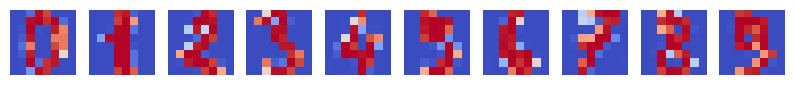

* Network weights (Evidence: 11, iT: 0.1668)


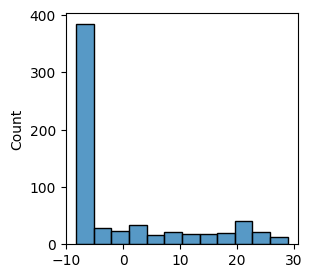

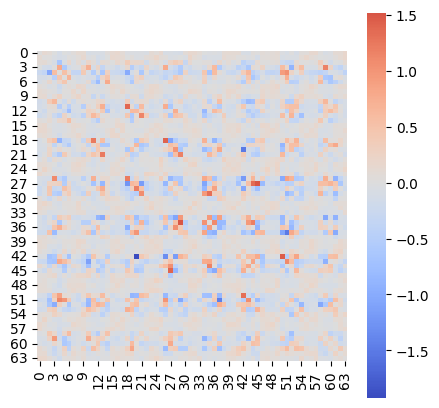

* Weight change (Evidence: 11, iT: 0.1668)


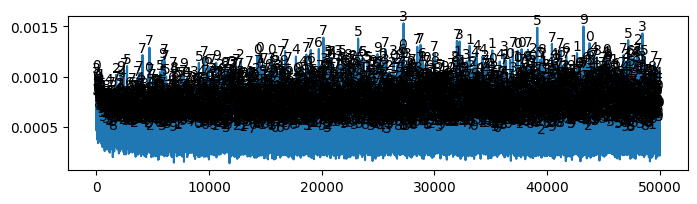

* Accuracy (Evidence: 11, iT: 0.1668)


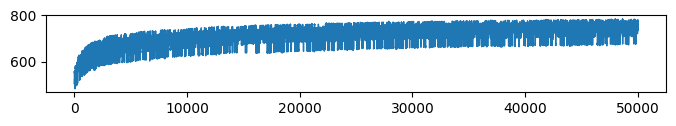

* Complexity (Evidence: 11, iT: 0.1668)


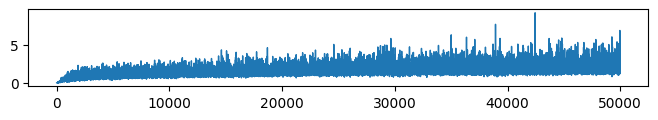

* VFE (Evidence: 11, iT: 0.1668)


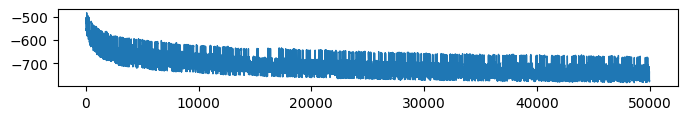

* Retrieval accuracy (Evidence: 11, iT: 0.1668)


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


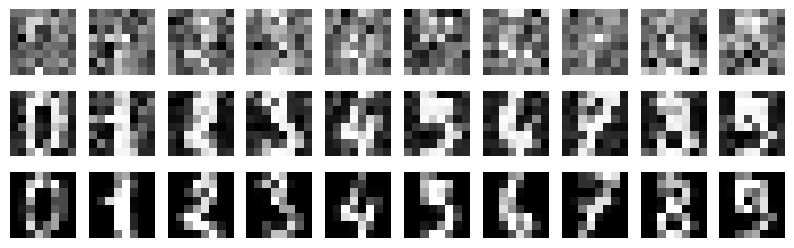

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


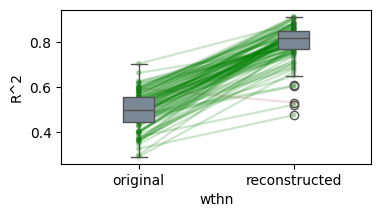

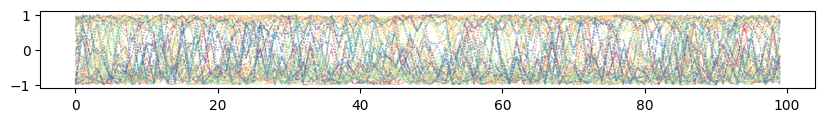

* Generalization accuracy (Evidence: 11, iT: 0.1668)


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


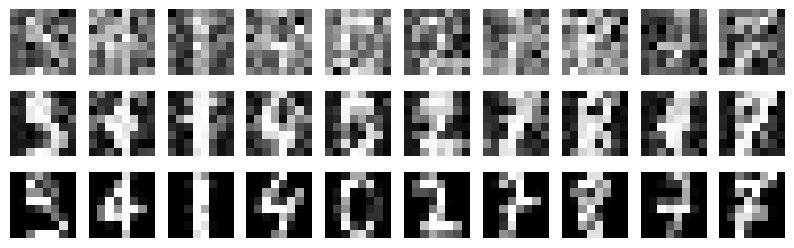

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


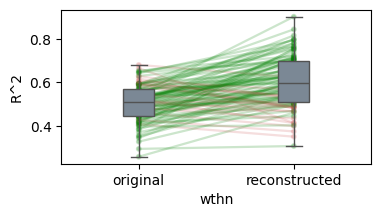

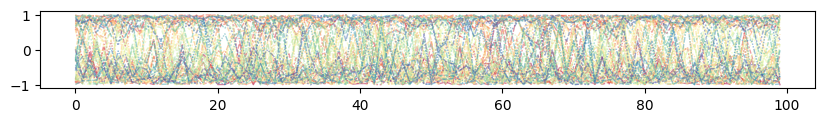

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


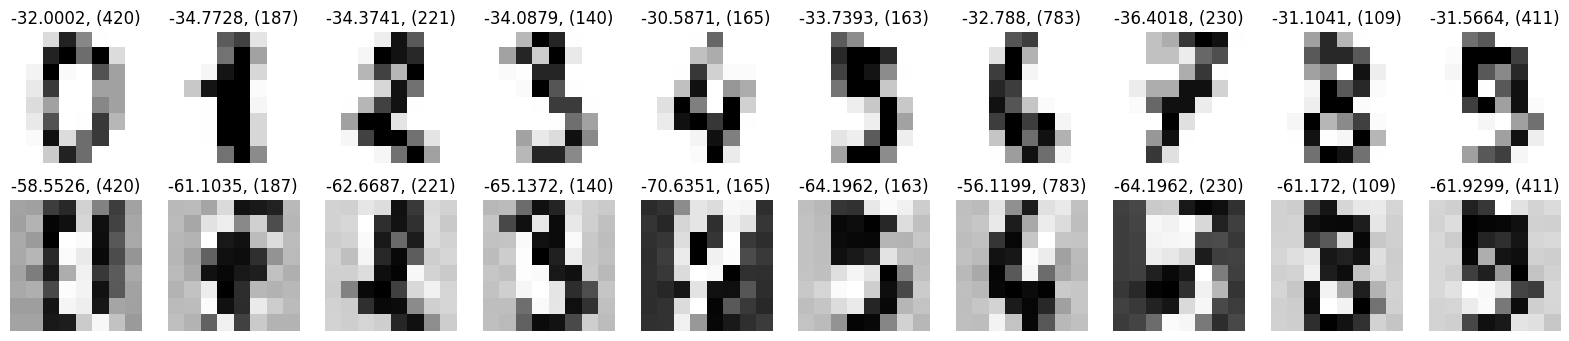

  ** Noise: 0.5


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


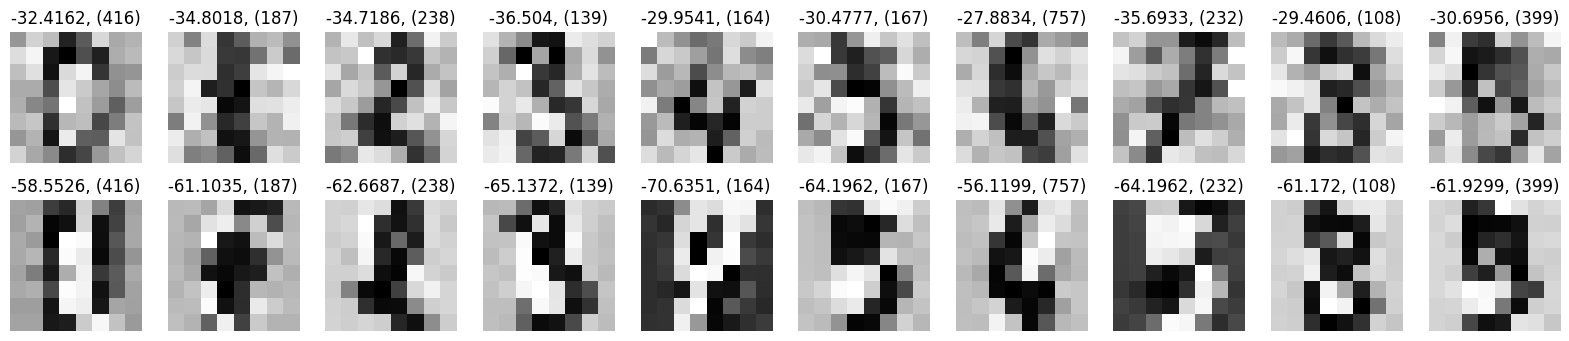

* Orthogonality


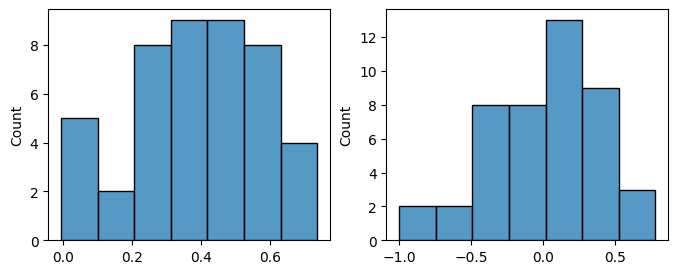

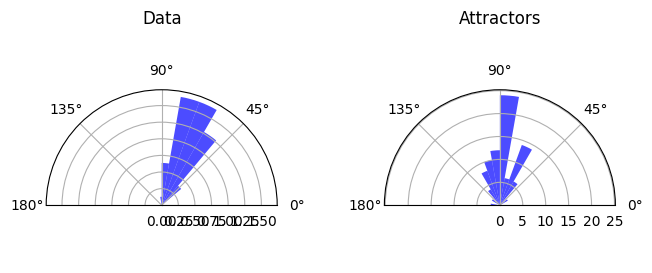

In [135]:
evidence_level = 11
inverse_temperature = 0.1668

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## High complexity - accuracy pumping

{'params': {'evidence_level': np.float64(16.0), 'inverse_temperature': np.float64(0.3593813663804626)}, 'nw': <simulation.network.AttractorNetwork object at 0x642025e50>, 'median_delta_r2_retrieval': np.float64(0.27), 'median_delta_r2_generalization': np.float64(-0.05050000000000002), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(27.571865380432584)}
* Visualize training data


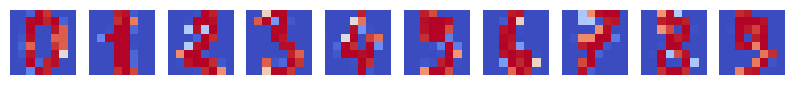

* Network weights (Evidence: 16, iT: 0.35938)


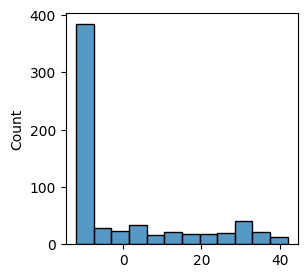

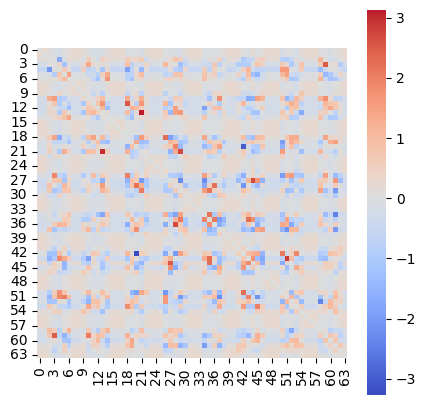

* Weight change (Evidence: 16, iT: 0.35938)


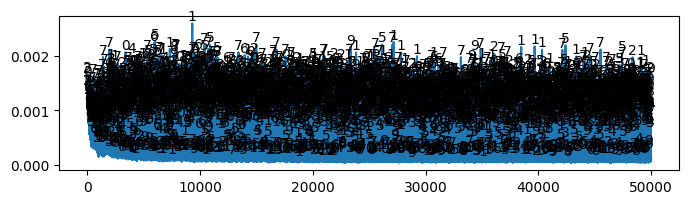

* Accuracy (Evidence: 16, iT: 0.35938)


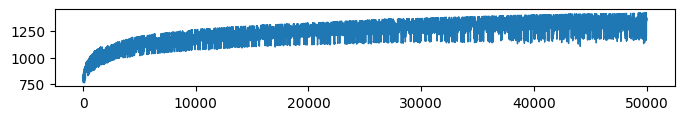

* Complexity (Evidence: 16, iT: 0.35938)


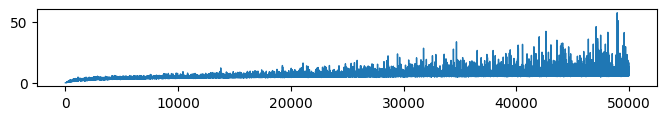

* VFE (Evidence: 16, iT: 0.35938)


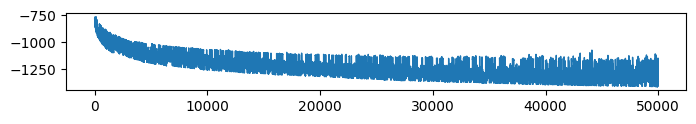

* Retrieval accuracy (Evidence: 16, iT: 0.35938)


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


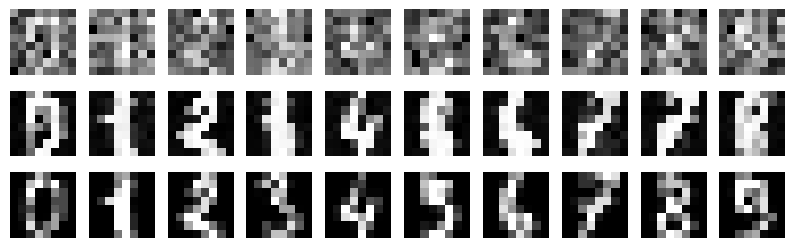

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


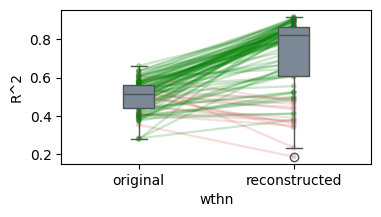

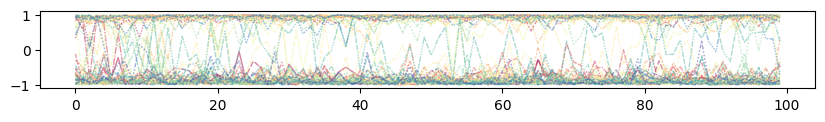

* Generalization accuracy (Evidence: 16, iT: 0.35938)


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


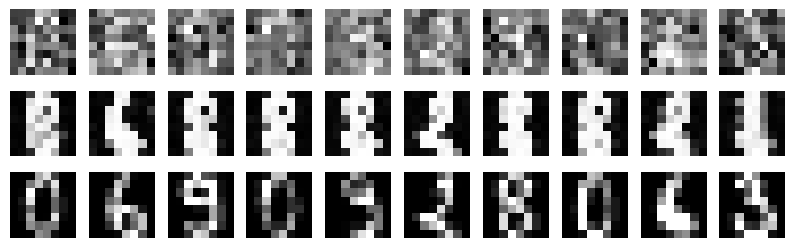

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


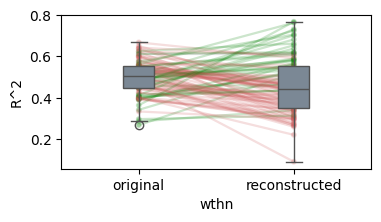

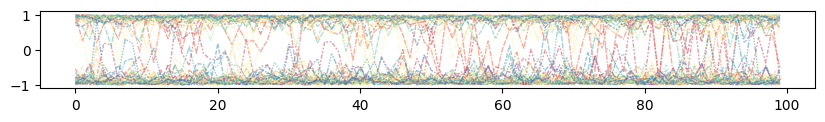

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


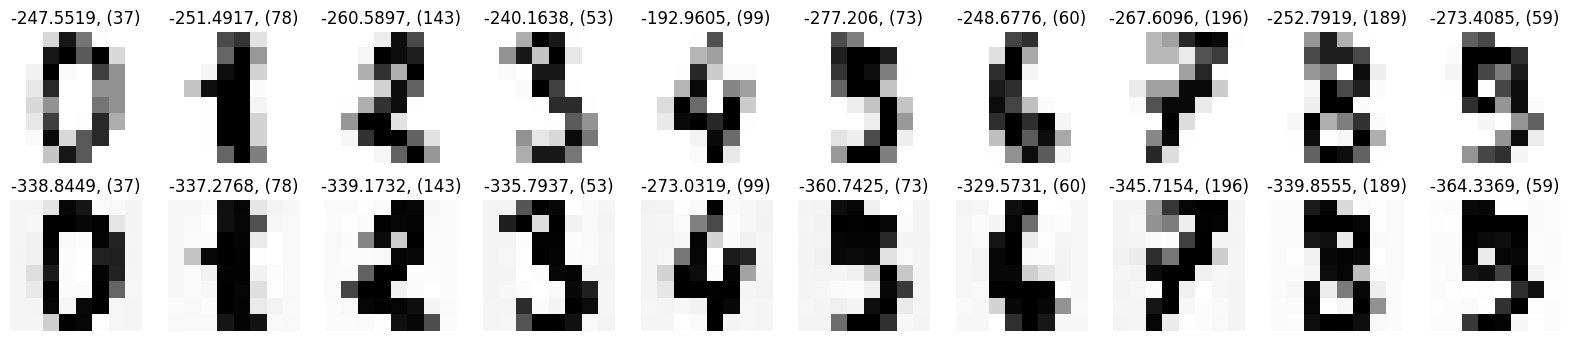

  ** Noise: 0.5


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


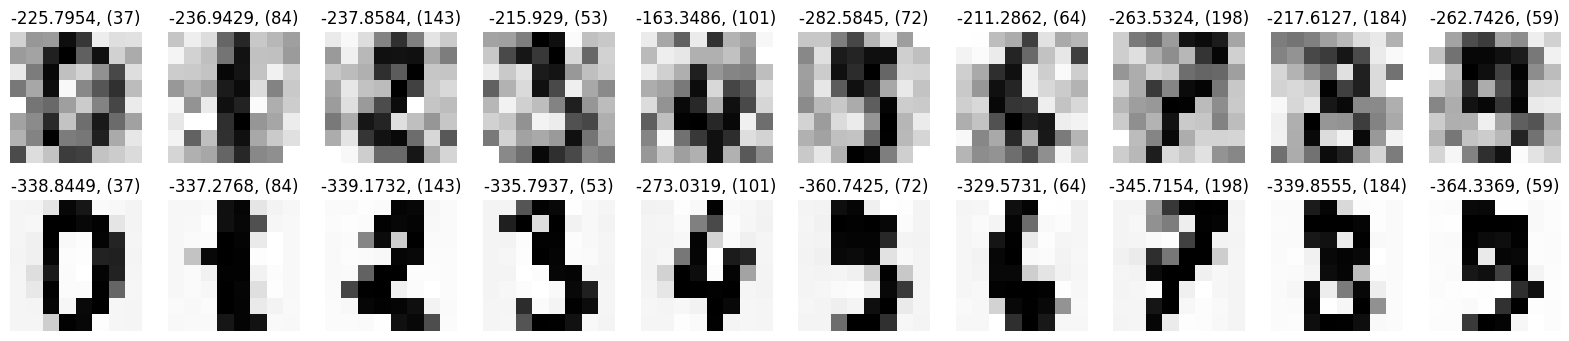

* Orthogonality


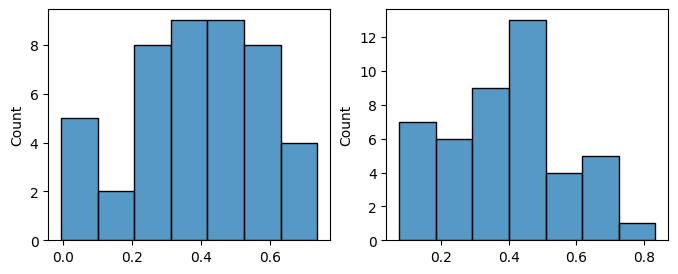

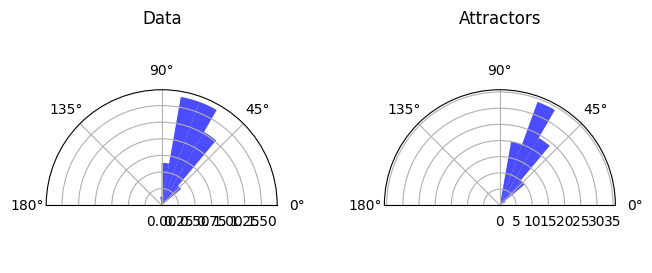

In [134]:
evidence_level = 16
inverse_temperature = 0.35938 # 2.78

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## Low complexity - oversimplified

{'params': {'evidence_level': np.float64(6.0), 'inverse_temperature': np.float64(0.027825594022071243)}, 'nw': <simulation.network.AttractorNetwork object at 0x817d9f350>, 'median_delta_r2_retrieval': np.float64(0.16449999999999998), 'median_delta_r2_generalization': np.float64(0.08450000000000002), 'num_attractors': 1, 'orthogonality_data': np.float64(29.937435612491395), 'orthogonality_attractors': np.float64(nan)}
* Visualize training data


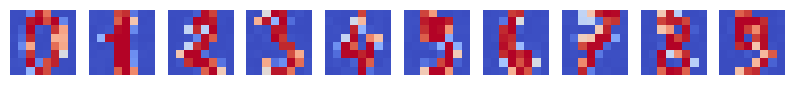

* Network weights (Evidence: 6, iT: 0.02782559)


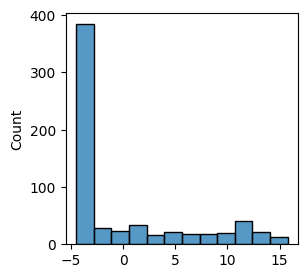

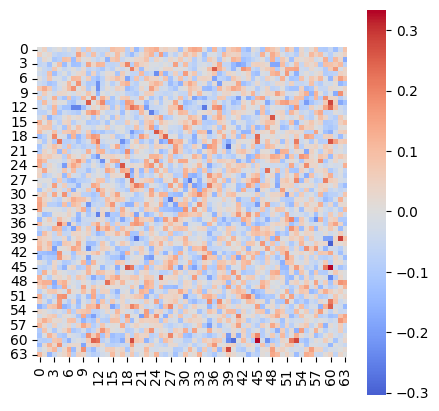

* Weight change (Evidence: 6, iT: 0.02782559)


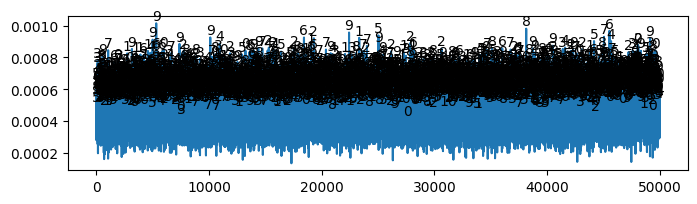

* Accuracy (Evidence: 6, iT: 0.02782559)


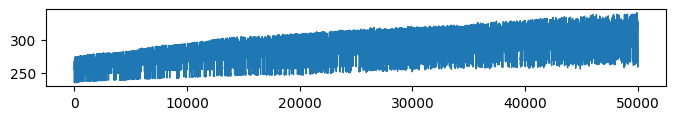

* Complexity (Evidence: 6, iT: 0.02782559)


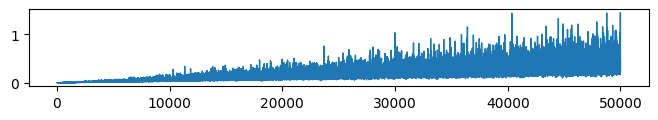

* VFE (Evidence: 6, iT: 0.02782559)


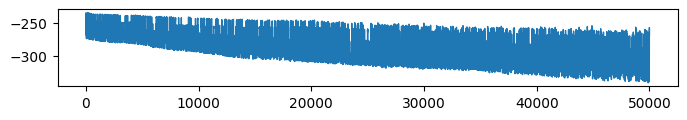

* Retrieval accuracy (Evidence: 6, iT: 0.02782559)


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


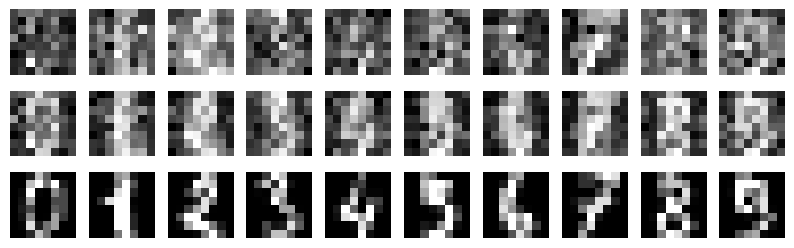

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


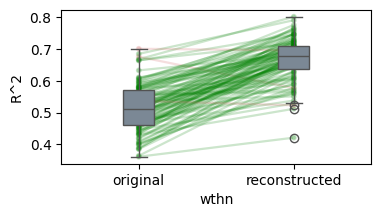

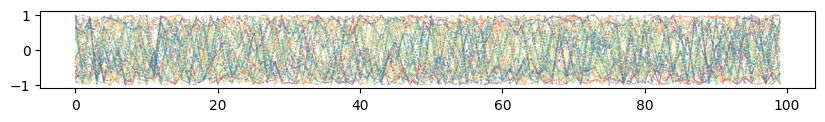

* Generalization accuracy (Evidence: 6, iT: 0.02782559)


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


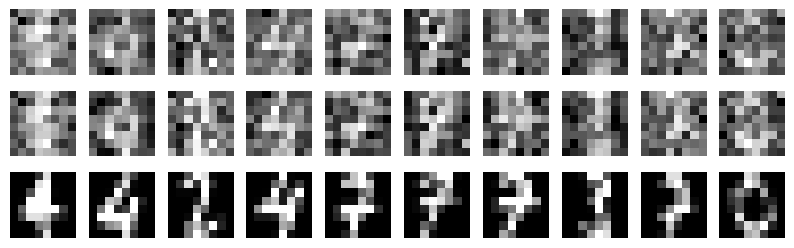

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


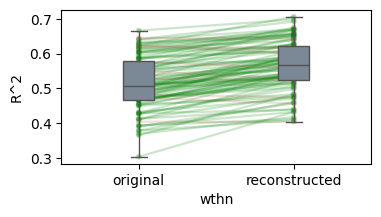

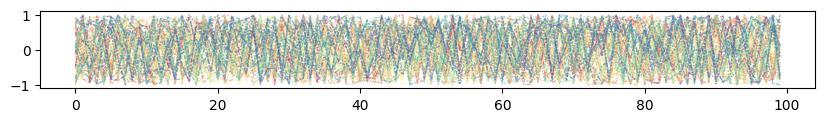

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


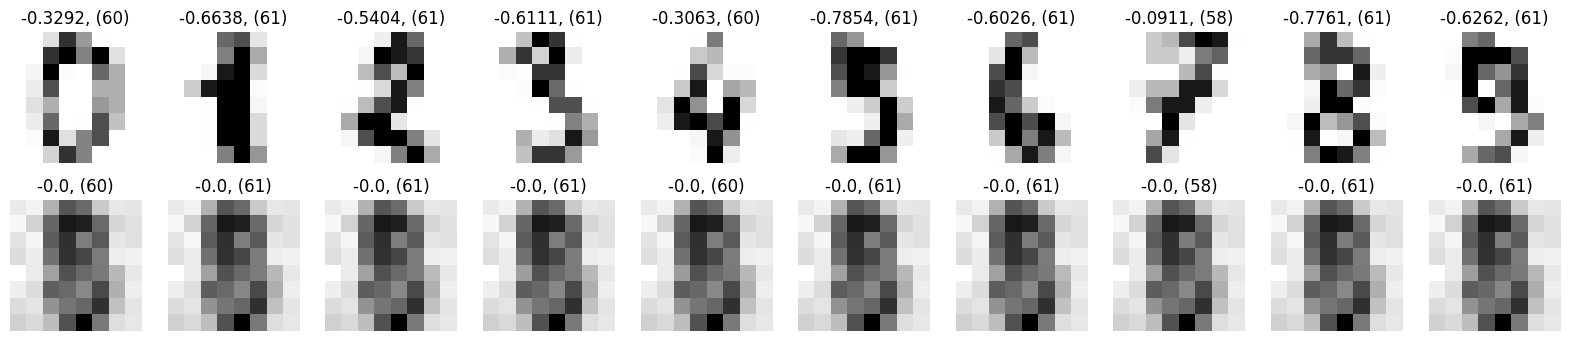

  ** Noise: 0.5


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


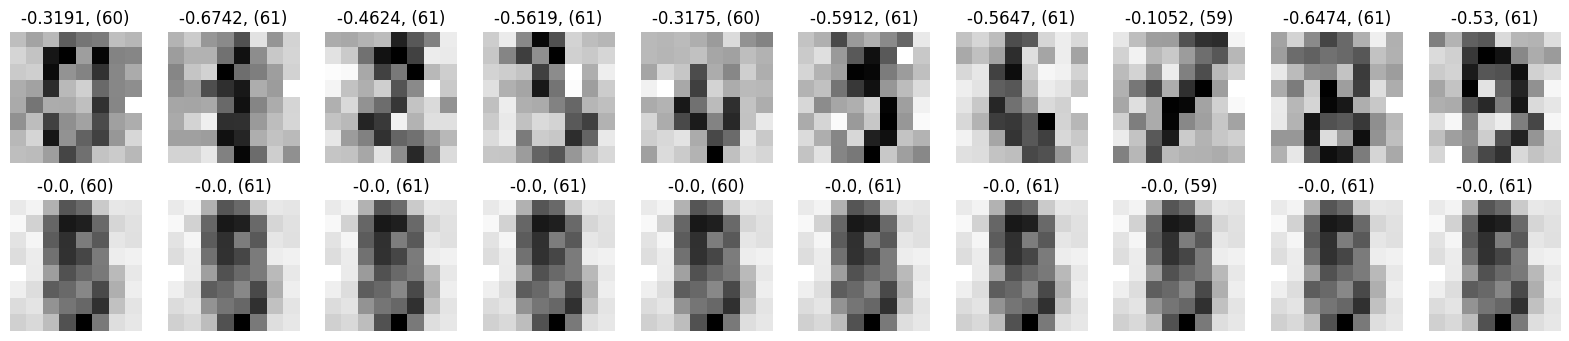

* Orthogonality


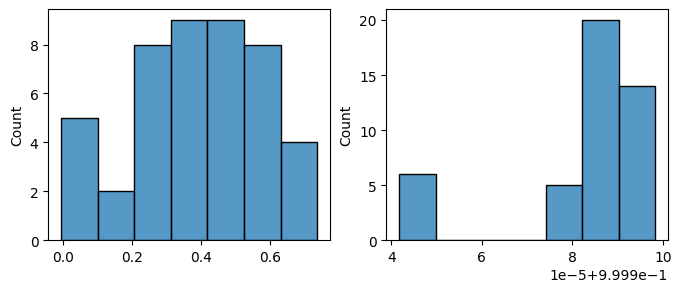

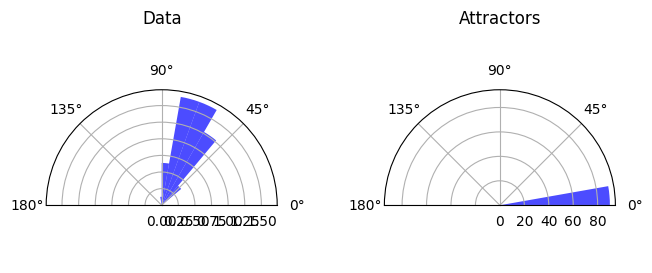

In [136]:
evidence_level = 6
inverse_temperature = 0.02782559 # 35.94

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.2,
                                "SNR": 1,
                                "inverse_temperature": 0.5,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## Illustrate prior mixing for optimal parameters

{'params': {'evidence_level': np.float64(11.0), 'inverse_temperature': np.float64(0.16681005372000582)}, 'nw': <simulation.network.AttractorNetwork object at 0x61605c410>, 'median_delta_r2_retrieval': np.float64(0.292), 'median_delta_r2_generalization': np.float64(0.07), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(17.34285659875748)}
  ** Noise: 0


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


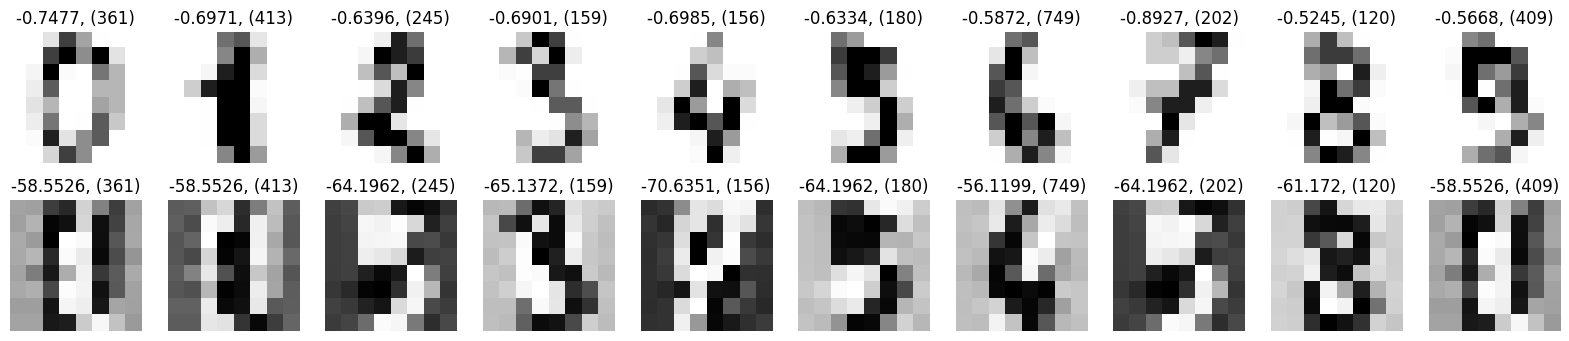

In [195]:
from simulation.utils import continous_inference_and_learning
from copy import deepcopy

evidence_level = 11
inverse_temperature = 0.1668

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

nw = deepcopy(matching_entry['nw'])

attractors = get_deterministic_attractors(nw=nw, data=train_data, noise_levels=[0], inverse_temperature=1)


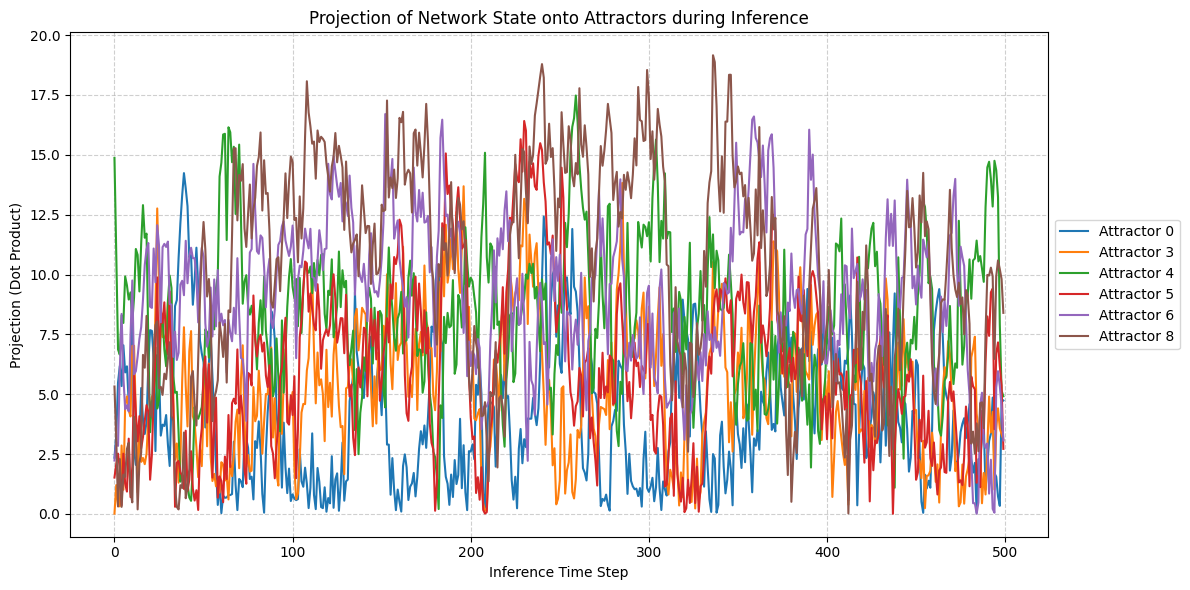

In [267]:
original_pattern = train_data[1] * matching_entry['params']['evidence_level'] * 0.01 + train_data[8] * matching_entry['params']['evidence_level'] * 0.01
SNR = 10
test_pattern = original_pattern #+ np.random.normal(0, original_pattern.std()/SNR, original_pattern.shape)
acts, _, _, _, _ = continous_inference_and_learning(nw, data=test_pattern, 
                                                            inverse_temperature=1, 
                                                            learning_rate=0.0, 
                                                            num_steps=500)
    
attractors_np = np.array(attractors) # Shape (num_attractors, num_nodes)

acts_np = np.array(acts) # Shape (num_steps, num_nodes)

num_steps_inference = acts_np.shape[0]
num_attractors = attractors_np.shape[0]
num_nodes = attractors_np.shape[1]

# Calculate projections
projections = np.zeros((num_attractors, num_steps_inference))

for t in range(num_steps_inference):
    current_activation = acts_np[t]
    # Project current activation onto each attractor
    projections[:, t] = np.abs(np.dot(attractors_np, current_activation))
    # Optional: Normalize if needed, e.g., by norm of attractors
    # norms_sq = np.sum(attractors_np**2, axis=1)
    # projections[:, t] = np.dot(attractors_np, current_activation) / norms_sq


# Plotting the projections over time
plt.figure(figsize=(12, 6))
for k in range(num_attractors):
    # Assuming attractors correspond to the order in train_data (digits 0-9)
    if k not in [1, 9, 2, 7]:
        plt.plot(projections[k, :], label=f'Attractor {k}') 

plt.xlabel("Inference Time Step")
plt.ylabel("Projection (Dot Product)")
plt.title("Projection of Network State onto Attractors during Inference")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Place legend outside
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()